In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from utils import *

In [11]:
results_folder = './results_data/xsubject_transform_module/RNN'

results_df = []
for model_id in range(1,3+1):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [12]:
results_df.head()

,F1_score,Subject,Rep_subject_order,Fold,Type,Shuffled,Rep_all,Model
0,0.992805,11.0,1,1,Train,False,1,1
1,0.990005,16.0,1,1,Train,False,1,1
2,0.997317,10.0,1,1,Train,False,1,1
3,1.000000,15.0,1,1,Train,False,1,1
4,0.963910,7.0,1,1,Train,False,1,1


In [13]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep_all'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep_subject_order'])

In [14]:
results_df.head()

,Shuffled,Type,Model,Rep_all,F1_score,Subject
0,False,Train,1,1,0.988439,20.612903
1,False,Train,1,2,0.988514,20.612903
2,False,Train,1,3,0.988117,20.612903
3,False,Train,1,4,0.989159,20.612903
4,False,Train,1,5,0.989064,20.612903


In [15]:
train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Val_Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns=['Rep_all']).\
rename(columns={'F1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score    Subject  Test_score    Subject
Shuffled Model                                               
False    1         0.988916  20.612903    0.952283  20.612903
         2         0.988098  20.612903    0.950460  20.612903
         3         0.986756  20.612903    0.944746  20.612903
True     1         0.416206  20.612903    0.175261  20.612903
         2         0.419578  20.612903    0.171660  20.612903
         3         0.427440  20.612903    0.169946  20.612903

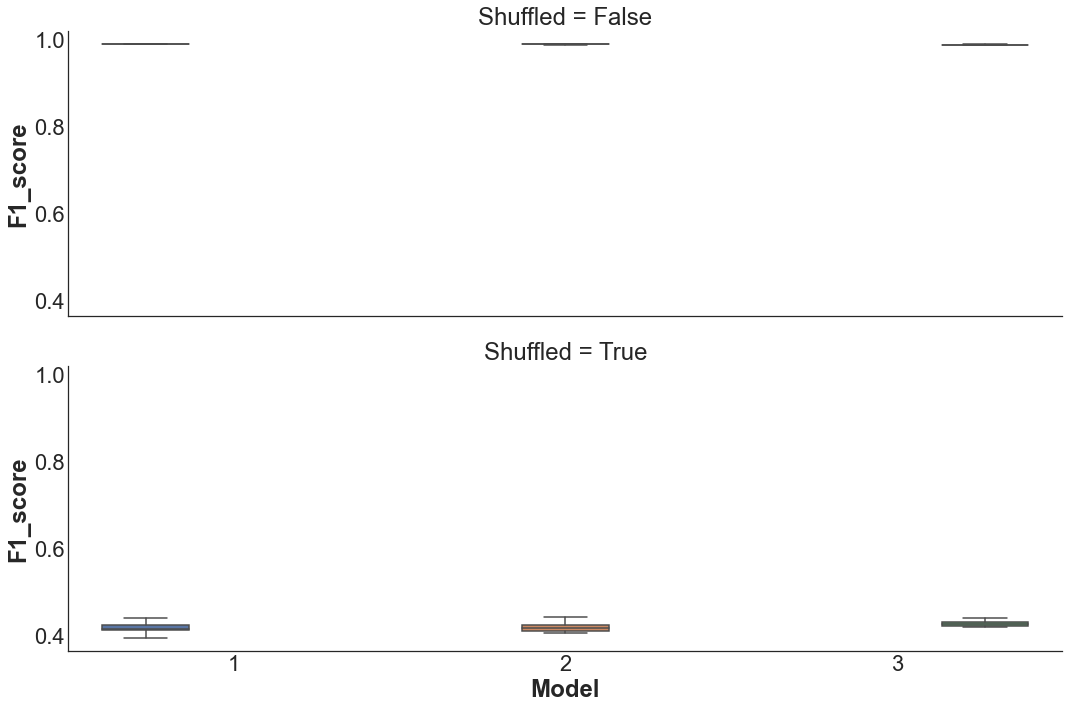

In [16]:


g = sns.catplot(data = train_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3)

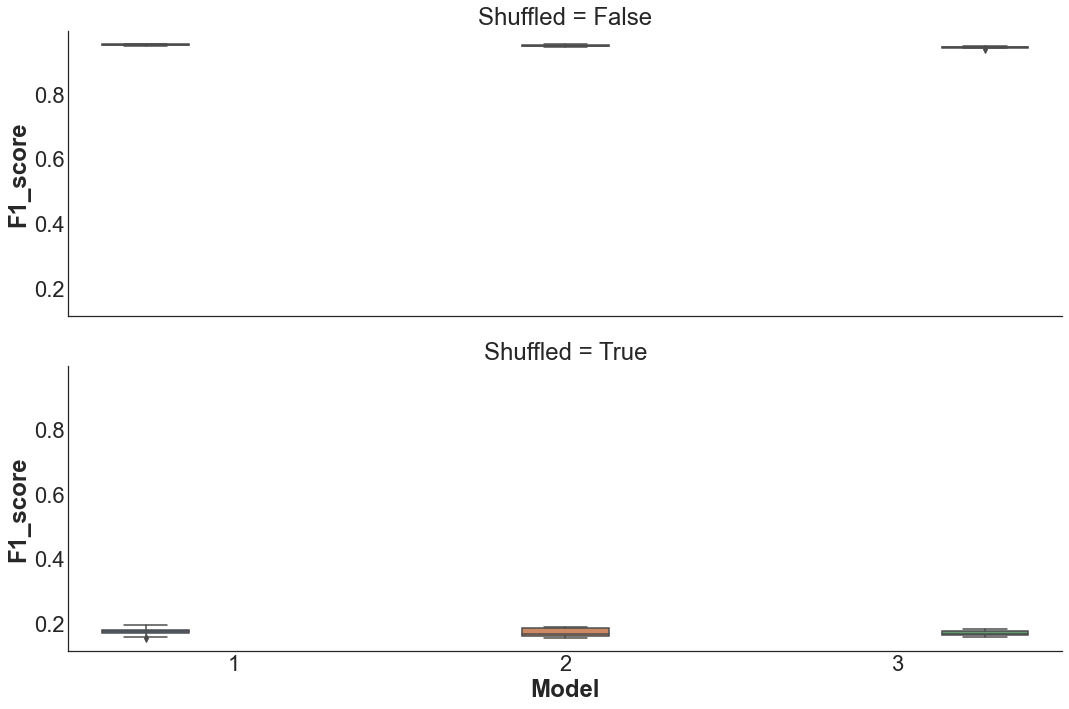

In [17]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'F1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3)

In [18]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [19]:
# Run ANOVA
model = ols('F1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.000221,2.0,36.672144,4.568521e-12
C(Type),0.030151,2.0,5003.279995,1.381354e-85
C(Model):C(Type),0.000127,4.0,10.501161,6.652296e-07
Residual,0.000244,81.0,NaN,NaN


In [20]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    1 - Train  1 - Val_Test  -0.0366  0.001 -0.0391 -0.0342   True
    1 - Train 1 - Val_Train   0.0001    0.9 -0.0024  0.0026  False
    1 - Train     2 - Train  -0.0008    0.9 -0.0033  0.0017  False
    1 - Train  2 - Val_Test  -0.0385  0.001 -0.0409  -0.036   True
    1 - Train 2 - Val_Train  -0.0011 0.8571 -0.0036  0.0013  False
    1 - Train     3 - Train  -0.0022 0.1363 -0.0046  0.0003  False
    1 - Train  3 - Val_Test  -0.0442  0.001 -0.0466 -0.0417   True
    1 - Train 3 - Val_Train  -0.0015 0.5544  -0.004  0.0009  False
 1 - Val_Test 1 - Val_Train   0.0367  0.001  0.0343  0.0392   True
 1 - Val_Test     2 - Train   0.0358  0.001  0.0333  0.0383   True
 1 - Val_Test  2 - Val_Test  -0.0018 0.3263 -0.0043  0.0007  False
 1 - Val_Test 2 - Val_Train   0.0355  0.001   0.033   0.038   

In [21]:
test_results_true_df = results_df.loc[(results_df.Type == 'Val_Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [22]:
# Run ANOVA
model = ols('F1_score ~ C(Model)', test_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.000309,2.0,23.499578,0.000001
Residual,0.000178,27.0,NaN,NaN


In [23]:
groups =  test_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(test_results_true_df['F1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0018 0.2677 -0.0047   0.001  False
     1      3  -0.0075  0.001 -0.0104 -0.0047   True
     2      3  -0.0057  0.001 -0.0086 -0.0029   True
----------------------------------------------------


In [64]:
#put things in dataframe and sort
summary_df.reset_index().loc[summary_df.reset_index().Shuffled == False].\
sort_values(by=['Train_score','Test_score'],ascending = False)#.reset_index().lo

,Shuffled,Model,Train_score,Test_score
0,False,1,0.944832,0.817078
7,False,8,0.941032,0.815630
8,False,9,0.930972,0.815061
10,False,11,0.930910,0.813283
9,False,10,0.919980,0.809497
11,False,12,0.916479,0.809345
4,False,5,0.910787,0.814137
1,False,2,0.910592,0.815662
2,False,3,0.892290,0.813455
5,False,6,0.886025,0.810343


<AxesSubplot:>

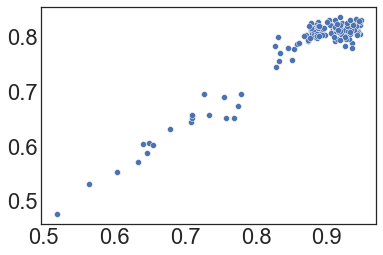

In [29]:
#checking correlaiton between train and test values - True data

X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

<AxesSubplot:>

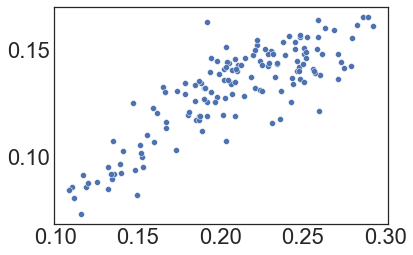

In [30]:
#checking correlaiton between train and test values - Shuffled data
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == True)]['F1_score'].values
Y = results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == True)]['F1_score'].values

sns.scatterplot(x = X, y = Y)

In [ ]:
X = results_df.loc[(results_df.Type == 'Train')&(results_df.Type == 'Test')]